In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Data path is assumed to be 'data' under repo root
def csv_loader(filename, datapath = "./data", stats = True):
    print('Loading %s.' % filename)
    path = os.path.join(datapath, filename)
    try:
        with open(path, 'rb') as f:
              data = pd.read_csv(f)
    except Exception as e:
        print('Unable to load data ', path, ':', e)
    if stats:
        print("{:d} rows of data loaded.".format(len(data)))
    return data

In [65]:
def merge_feature(df_base, df_merge, primary_key = "SK_ID_CURR", rename = dict(), suffixes = ("", "")):
    df_merge = df_merge.rename(columns=rename)
    df_base = df_base.merge(df_merge, on = primary_key, how = "left", suffixes = suffixes)
    return df_base

## bureau.csv

In [4]:
df_bureau = csv_loader("bureau.csv")
df_bureau.head(3)

Loading bureau.csv.
1716428 rows of data loaded.


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [5]:
df_bureau.describe(include = "all")

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1716428,1716428,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1716428,1.716428e+06,4.896370e+05
unique,NaN,NaN,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN
top,NaN,NaN,Closed,currency 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer credit,NaN,NaN
freq,NaN,NaN,1079273,1715020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251615,NaN,NaN
mean,2.782149e+05,5.924434e+06,NaN,NaN,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,NaN,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,NaN,NaN,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,NaN,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,NaN,NaN,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,NaN,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,NaN,NaN,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,NaN,NaN,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,NaN,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,NaN,NaN,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,NaN,-3.300000e+01,1.350000e+04


# application{train|test}.csv

In [6]:
df_train = csv_loader("application_train.csv")
df_test = csv_loader("application_test.csv")

Loading application_train.csv.
307511 rows of data loaded.
Loading application_test.csv.
48744 rows of data loaded.


In [7]:
df_train["train_test"] = "train"
df_test["train_test"] = "test"
# base feature table only inculde an ID is in train/test
df_feat = pd.concat([df_train[["SK_ID_CURR", "train_test"]], df_test[["SK_ID_CURR", "train_test"]]])
print(df_feat.head(1))
print(df_feat.tail(1))

   SK_ID_CURR train_test
0      100002      train
       SK_ID_CURR train_test
48743      456250       test


## Feature Engineering

### SK_ID_BUREAU

In [8]:
bureau_hist = df_bureau.groupby("SK_ID_CURR").count()[["SK_ID_BUREAU"]].reset_index() # base feature table only inculde count bureau
df_feat = merge_feature(df_feat, bureau_hist, rename = {"SK_ID_BUREAU" : "count_bureau"})
df_feat.head(3)

,SK_ID_CURR,train_test,count_bureau
0,100002,train,8.0
1,100003,train,4.0
2,100004,train,2.0


In [26]:
# ID with no bureau evaluation
df_feat[["count_bureau"]].isnull().sum(axis=0)
df_feat["no_bureau"] = df_feat[["count_bureau"]].isnull()
df_feat.head(1)

,SK_ID_CURR,train_test,count_bureau,no_bureau
0,100002,train,8.0,False


In [28]:
df_feat.groupby("train_test")[["no_bureau"]].describe()

no_bureau                      
               count unique    top    freq
train_test                                
test           48744      2  False   42320
train         307511      2  False  263491

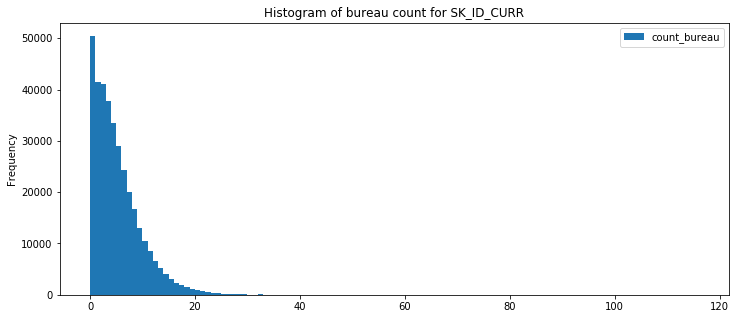

In [29]:
df_feat["count_bureau"] = df_feat["count_bureau"].fillna(0)
df_feat[["count_bureau"]].plot.hist(bins = int(max(df_feat["count_bureau"])), 
                      title = "Histogram of bureau count for SK_ID_CURR", figsize = (12, 5))
plt.show()

In [30]:
# Large count of Bureau (if one has bureau number more than 80% of ppl have)
sorted_bureau_hist = df_feat.sort_values("count_bureau").reset_index(drop = True)
sorted_bureau_hist.head(10)

,SK_ID_CURR,train_test,count_bureau,no_bureau
0,425815,train,0.0,True
1,187540,train,0.0,True
2,306845,test,0.0,True
3,349804,train,0.0,True
4,306876,test,0.0,True
5,306896,test,0.0,True
6,187520,train,0.0,True
7,187544,train,0.0,True
8,349807,train,0.0,True
9,445679,train,0.0,True


In [39]:
count_bureau_90 = sorted_bureau_hist.iloc[int(0.9 * len(sorted_bureau_hist))]["count_bureau"]
print("90% ppl has bureau less than {:f}".format(count_bureau_90))
sorted_bureau_hist["large_bureau_count"] = sorted_bureau_hist.count_bureau > count_bureau_90
sorted_bureau_hist.tail(3)

90% ppl has bureau less than 11.000000


,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count
356252,318065,test,78.0,False,True
356253,169704,train,94.0,False,True
356254,120860,train,116.0,False,True


In [40]:
df_feat = merge_feature(df_feat, sorted_bureau_hist[["SK_ID_CURR", "large_bureau_count"]])
df_feat.head(1)

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count
0,100002,train,8.0,False,False


### DAYS_CREDIT

In [52]:
col = "DAYS_CREDIT"
creditdays_hist = df_bureau.groupby("SK_ID_CURR")[[col]].aggregate(["mean", "max", "min", "std"]).reset_index()
creditdays_hist.head()

SK_ID_CURR  DAYS_CREDIT                       
                     mean  max   min         std
0     100001  -735.000000  -49 -1572  489.942514
1     100002  -874.000000 -103 -1437  431.451040
2     100003 -1400.750000 -606 -2586  909.826128
3     100004  -867.000000 -408 -1326  649.124025
4     100005  -190.666667  -62  -373  162.297053

c:\miniconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


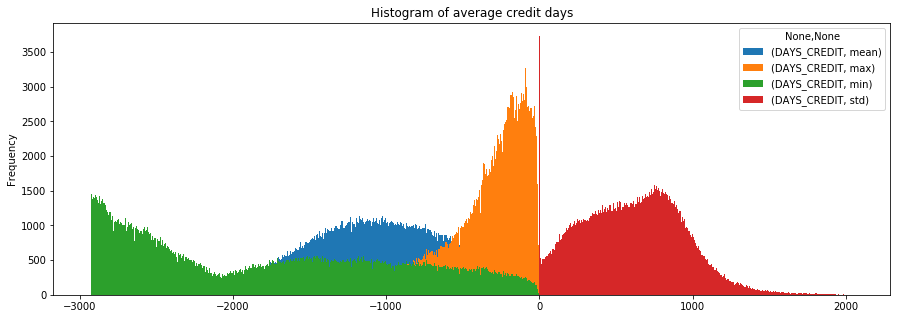

In [60]:
creditdays_hist.drop("SK_ID_CURR", axis = 1).plot.hist(
    bins = 1000, title = "Histogram of average credit days", figsize = (15, 5) )
plt.show()

In [61]:
df_feat = merge_feature(df_feat,creditdays_hist, rename = {"SK_ID_BUREAU" : "count_bureau"})

c:\miniconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
c:\miniconda3\lib\site-packages\pandas\core\generic.py:3108: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [62]:
df_feat.head()

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"(DAYS_CREDIT, mean)","(DAYS_CREDIT, max)","(DAYS_CREDIT, min)","(DAYS_CREDIT, std)"
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025
3,100006,train,0.0,True,False,NaN,NaN,NaN,NaN
4,100007,train,1.0,False,False,-1149.00,-1149.0,-1149.0,NaN


In [67]:
# Let the one with longest credict days take charge
longest_creadit = df_bureau.sort_values("DAYS_CREDIT", ascending = False).groupby("SK_ID_CURR").head(1)
longest_creadit.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
218508,405791,6008179,Active,currency 1,0,0,NaN,NaN,NaN,0,NaN,654993.0,NaN,0.0,Another type of loan,-5,NaN
1021119,453003,5922679,Active,currency 1,0,0,-492.0,NaN,NaN,0,2751133.5,1459602.0,NaN,0.0,Another type of loan,-73,NaN


In [68]:
df_feat = merge_feature(df_feat, longest_creadit, suffixes = ("", "_mainb"))
df_feat.head(3)

,SK_ID_CURR,train_test,count_bureau,no_bureau,large_bureau_count,"(DAYS_CREDIT, mean)","(DAYS_CREDIT, max)","(DAYS_CREDIT, min)","(DAYS_CREDIT, std)",SK_ID_BUREAU,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,train,8.0,False,False,-874.00,-103.0,-1437.0,431.451040,6158909.0,...,NaN,40.5,0.0,31988.565,0.0,31988.565,0.0,Credit card,-24.0,0.0
1,100003,train,4.0,False,False,-1400.75,-606.0,-2586.0,909.826128,5885880.0,...,NaN,0.0,0.0,810000.000,0.0,810000.000,0.0,Credit card,-43.0,NaN
2,100004,train,2.0,False,False,-867.00,-408.0,-1326.0,649.124025,6829134.0,...,-382.0,0.0,0.0,94537.800,0.0,0.000,0.0,Consumer credit,-382.0,NaN


### CREDIT_DAY_OVERDUE

With 305811 customers, 301947 have 0-day overdue.


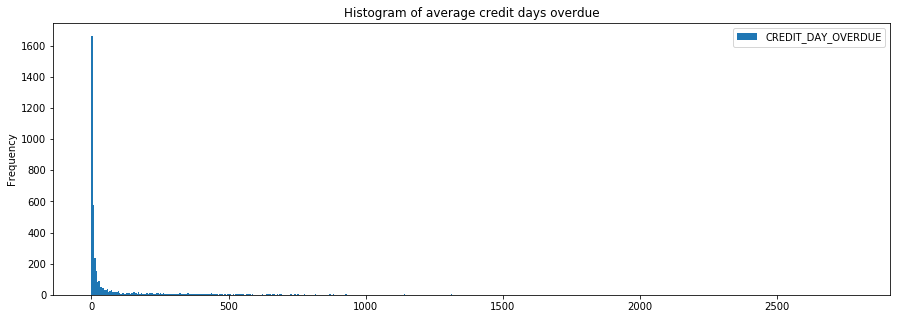

In [69]:
col = "CREDIT_DAY_OVERDUE"
creditdays_hist = df_bureau.groupby("SK_ID_CURR").mean()[[col]]
print("With {:d} customers, {:d} have 0-day overdue.".format(len(creditdays_hist), sum(creditdays_hist[col] == 0)))
creditdays_hist[creditdays_hist[col] != 0].plot.hist(
    bins = int(max(creditdays_hist[col])/5),
    title = "Histogram of average credit days overdue", figsize = (15, 5) )
plt.show()

In [70]:
df_feat.to_csv("./data/bureau_features.csv", index = False)